# Quantized Models Inference

In this file we will carry out the inference using the Face Detector and the Face Mask Classifier we've developed in the other two files.

However, this time we will use the quantized models.
Benefits of Quantized models :


*   Fast execution
*   Smaller size
*   Support execution on Mobiles and other embedded devices because of their execution of integer datatypes.

Reference : https://pytorch.org/blog/introduction-to-quantization-on-pytorch/





In [13]:
#Code to connect to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Libraries

In [14]:

import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms
!pip install kornia
import matplotlib.pyplot as plt
from kornia.utils import image_to_tensor,tensor_to_image
import cv2
from PIL import Image
font_scale=1
thickness = 2
red = (0,0,255)
green = (0,255,0)
blue = (255,0,0)
font=cv2.FONT_HERSHEY_SIMPLEX


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


### Loading Face Detector and Classifier models

In [15]:
#Loading models.
# Replace the path with the path where models are stored

detector_path = '/content/drive/My Drive/covid/quant_detector.pth'
classifier_path = '/content/drive/My Drive/covid/quant_classifier.pth'


quant_detector = torch.load(detector_path)
quant_classifier = torch.load(classifier_path)

quant_detector.to(device)
quant_classifier.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Carrying out inference

In [0]:
#Transforms function. This was missing in the previous submission

train_transforms = transforms.Compose([
                                       transforms.Resize((224,224)),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3, fill=0),

                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

In [0]:
#Function to carry out inference

def detector(model,classifier,image):
  img = cv2.imread(image)
  img_RGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img_scaled = img_RGB/255.0
  img_final = img_scaled
  to_send_image = img_final
  img_final = image_to_tensor(image = img_final,keepdim=False)

  img_final = img_final.to(device,dtype=torch.float)
    
  model.eval()
  output = model(list(img_final))
  boxes=[]
  for each_output in output[0]['boxes'].cpu().detach().numpy():
    boxes.append(list(each_output))
    

  # img_final = tensor_to_image(img_final)

  fig, ax = plt.subplots(1, 1, figsize=(16, 8))
  frame = cv2.imread(image)
  img_final=frame
  frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)  
  for box in boxes:
    
    face = frame[int(box[1]):int(box[3]),int(box[0]):int(box[2])]
    try:    
      pil_image = Image.fromarray(face, mode = "RGB")
    

      pil_image = train_transforms(pil_image)
      image = pil_image.unsqueeze(0)

      if device  == torch.device('cuda'):
        image = image.cuda()
      result = classifier(image)
      _, maximum = torch.max(result.data, 1)
      prediction = maximum.item()
      if prediction==0:
        cv2.putText(img_final,'No Mask', ( int(box[0]) , int(box[3]+20)) , font,font_scale,red,thickness)
      elif prediction==1:
        cv2.putText(img_final,'Mask', ( int(box[0]) , int(box[3]+20) ) , font,font_scale,green,thickness)
      cv2.rectangle(img_final,(box[0],box[1]),(box[2],box[3]),(220,0,0),3)
    except ValueError:
      pass
  img_final = cv2.cvtColor(img_final,cv2.COLOR_RGB2BGR)

    
  print()       
  ax.set_axis_off()
  ax.imshow(img_final)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "



CPU times: user 232 ms, sys: 67.2 ms, total: 299 ms
Wall time: 306 ms


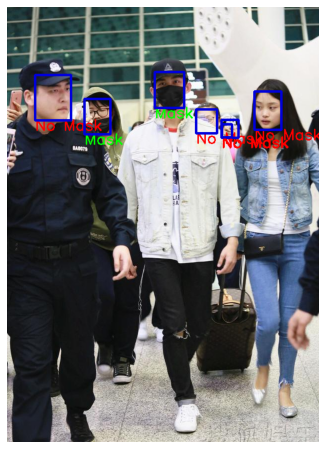

In [18]:
%%time

IMAGE_PATH = '/content/drive/My Drive/covid/test_00000843.jpg'

image = IMAGE_PATH

detector(quant_detector,quant_classifier,image)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "



CPU times: user 158 ms, sys: 51.6 ms, total: 210 ms
Wall time: 214 ms


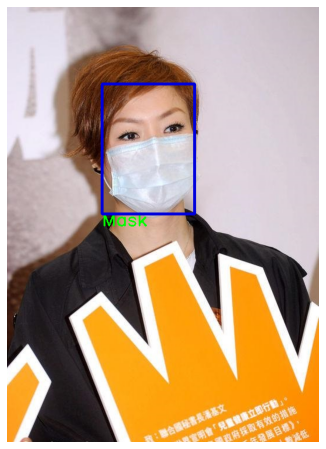

In [19]:
%%time

IMAGE_PATH = '/content/drive/My Drive/covid/test_00000857.jpg'

image = IMAGE_PATH

detector(quant_detector,quant_classifier,image)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "



CPU times: user 149 ms, sys: 81.6 ms, total: 230 ms
Wall time: 236 ms


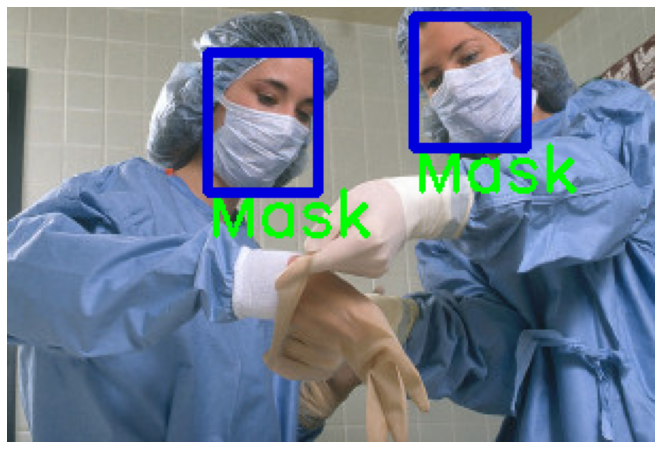

In [20]:
%%time

IMAGE_PATH = '/content/drive/My Drive/covid/test_00000346.jpg'

image = IMAGE_PATH

detector(quant_detector,quant_classifier,image)